In [1]:
import os; os.chdir("../")
import sys; sys.path.append("scripts")

In [2]:
import torch
import yaml
from utils import set_seed, init_tokenizer
from utils import HF_NAME_MAP
from transformers import (
    BitsAndBytesConfig,
    AutoModelForCausalLM, AutoTokenizer,
    GenerationConfig, 
    StoppingCriteriaList,
)

config_path = 'configs/basic.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
set_seed(config['seed'])

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
STOP

In [ ]:
"""
Please calculate the solution step-by-step and conclude the answer with '\n#### ' followed by the result.
There are some oranges in a basket. Ana spends 3 minutes peeling an orange and Jane spends 4 minutes doing the same. If Ana and Jane start picking oranges from this basket to peel at the same time, how many more oranges will Ana have peeled than Jane after an hour?
"""

In [ ]:
# import subprocess
# from transformers import BitsAndBytesConfig, QuantoConfig
# test_qt_configs = [
#     BitsAndBytesConfig(load_in_4bit=True),
#     BitsAndBytesConfig(load_in_8bit=True),
#     QuantoConfig(weights="int8"),
# ]

# def get_gpu_memory_by_pid(pid):
#     try:
#         # nvidia-smi로 프로세스 정보 조회
#         result = subprocess.run(
#             ["nvidia-smi", "--query-compute-apps=pid,used_memory", "--format=csv,noheader,nounits"],
#             stdout=subprocess.PIPE, text=True
#         )

#         # 결과 파싱
#         processes = result.stdout.strip().split("\n")
#         for process in processes:
#             process_info = process.split(", ")
#             process_pid = int(process_info[0])
#             used_memory = int(process_info[1])  # GPU 메모리 사용량 (MB 단위)

#             if process_pid == pid:
#                 return used_memory
#         return None  # 해당 PID가 GPU에서 실행 중이지 않음

#     except FileNotFoundError:
#         print("nvidia-smi 명령어를 찾을 수 없습니다. NVIDIA 드라이버가 설치되어 있는지 확인하세요.")
#         return None
#     except Exception as e:
#         print(f"에러 발생: {e}")
#         return None

# # 예시: 특정 PID의 GPU 메모리 사용량 확인
# pid = 5765  # 확인하려는 PID
# gpu_memory = get_gpu_memory_by_pid(pid)
# if gpu_memory is not None:
#     print(f"PID {pid}의 GPU 메모리 사용량: {gpu_memory} MB")
# else:
#     print(f"PID {pid}는 GPU에서 실행 중이지 않습니다.")

# model_name = "sft_llama-1b"
# task_name = "gsm8k"
# model_path = f"models/{model_name}_{task_name}"
# model_type, pt_name = model_name.split("_")
# hf_name = HF_NAME_MAP[pt_name]

# pid = os.getpid()

# for qt in test_qt_configs:
#     model = AutoModelForCausalLM.from_pretrained(
#         model_path,
#         quantization_config=qt,
#         **config['model'][pt_name]
#     )
#     gpu_memory = get_gpu_memory_by_pid(pid)
#     print(f"QT: {qt}, GPU Memory: {gpu_memory} MB")
#     model.cpu()
#     del model

#     torch.cuda.empty_cache()

PID 5765는 GPU에서 실행 중이지 않습니다.


In [ ]:
model_name = "sft_llama-1b"
task_name = "gsm8k"
model_path = f"models/{model_name}_{task_name}"
model_type, pt_name = model_name.split("_")
hf_name = HF_NAME_MAP[pt_name]
tokenizer = AutoTokenizer.from_pretrained(hf_name)
init_tokenizer(tokenizer)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=BitsAndBytesConfig(**config['qt']),
    **config['model'][pt_name]
)

{'load_in_8bit': True}

In [ ]:
activation = {}

def get_activation(layer_nm):
    def hook(module, input, output):
        if layer_nm == "self_attn":
            output = output[0]
        activation[layer_nm] = output.detach().cpu()
    return hook
self_attn = model.model.layers[-1].self_attn
mlp = model.model.layers[-1].mlp
handler1 = self_attn.register_forward_hook(get_activation('self_attn'))
handler2 = mlp.gate_proj.register_forward_hook(get_activation('gate_proj'))

In [ ]:
text = "The quick brown fox jumps over the lazy dog"
input_ids = tokenizer.encode(text, return_tensors="pt")
output = model(input_ids)
handler1.remove()
handler2.remove()

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [ ]:
input_ids.shape, activation['self_attn'].shape, activation['gate_proj'].shape

(torch.Size([1, 10]), torch.Size([1, 10, 2048]), torch.Size([1, 10, 8192]))

In [ ]:
neurons = mlp.act_fn(activation['gate_proj'][0, -1])

In [ ]:
neurons.max(), neurons.min(), neurons.mean(), neurons.std()

(tensor(6.7227, dtype=torch.float16),
 tensor(-0.2786, dtype=torch.float16),
 tensor(0.0792, dtype=torch.float16),
 tensor(0.3706, dtype=torch.float16))

In [ ]:
import matplotlib.pyplot as plt

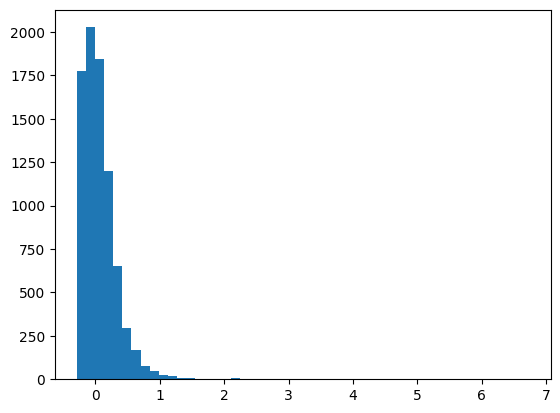

In [ ]:
plt.hist(neurons.numpy(), bins=50)
plt.show()

In [ ]:
neurons

tensor([-0.0828,  0.3142,  0.0468,  ...,  0.1896,  0.0750,  0.0922],
       dtype=torch.float16)

In [ ]:
thres = neurons.float().quantile(0.99)
torch.where(neurons > thres)

(tensor([  41,  100,  287,  396,  402,  576,  640,  840,  870,  936, 1070, 1071,
         1143, 1210, 1327, 1346, 1401, 1546, 1579, 1619, 1787, 1788, 1879, 1949,
         2027, 2059, 2072, 2260, 2307, 2545, 2548, 2627, 2636, 2773, 2785, 2859,
         2999, 3106, 3307, 3316, 3449, 3497, 3675, 3879, 4407, 4549, 4587, 4758,
         4775, 4807, 4811, 4817, 4870, 4909, 5394, 5450, 5621, 5782, 5792, 5881,
         5924, 6036, 6278, 6283, 6364, 6517, 6747, 6805, 6813, 6853, 6888, 7006,
         7358, 7375, 7598, 7670, 7728, 7811, 7874, 7996, 8092, 8120]),)

In [ ]:
thres

tensor(1.1087)